# Data Cleaning

In [1]:
'''
Import required packages and libraries for data exploration
'''
import pandas as pd

In [3]:
'''
Set up file path and data handling objects
'''
PATH = "../data/reviews.csv"
data = pd.read_csv(PATH)

## Remove Irrelevant Data Points
The first stage of data cleaning is to identify and remove data points that aren't related to our task. In "Amazon Fine Food Reviews", we have many different product reviews including: pet food, medicine, microwavable food, fine foods, etc.
- Is this category of food or type of review relevant to our task?
- Would removing this type of review from the data improve the accuracy of our model?
- If we remove this type of review, how will it effect our training process (would there be too little data remaining?)

## Remove Uncecessary Columns
- What columns are necessary for our model? 
- Is there anything that needs to be removed?

## Case Sensitivity
Convert the input features in the raw dataset into a case insensitive format (all lowercase/uppercase) to reduce the amount of distinct words in the data.

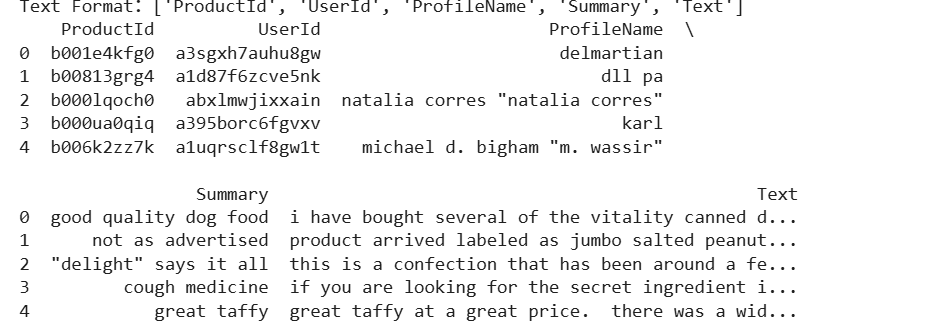

## Remove Filler Words
Some words like "I", "the", "a", etc. don't impact the sentiment of the text content. Remove these words from all review content so there is less redundant features for the final model.

## Punctuation Handling
Some words that contain punctuation can be recorded as separate features without punctuation handling (e.g., "Steve's pizza is great!" and "Steve makes great pizza!").

| is | great | great! | makes | pizza | pizza! | Steve | Steve's |
|----|-------|--------|-------|-------|--------|-------|---------|
|1   | 1     | 1      | 1     | 1     | 1      | 1     | 1       |

We want to remove uncessesary punctuation so that we don't have duplicates of effectively the same word.
| is | great | makes | pizza | Steve |
|----|-------|-------|-------|-------|
| 1  | 2     | 1     | 2     | 2     |

Doing this prevents our model from interpreting duplicate words as two separate features and reduces the number of dimensions our model has to process (increasing efficiency).

## Dependency Parsing Split
In this section we need to split the dataset into single entity and multiple entity data points. This step is necessary because the framework for our model requires that single entity data points are handled by **model A** and multiple entity data points are handled by **model B**.

## Word Embedding